# Off Policy Simulation - Open Bandit Dataset
---
This notebook demonstrates an example of conducting OPE of Bernoulli Thompson Sampling (BernoulliTS) as an evaluation policy. We use some OPE estimators and logged bandit data generated by running the Random policy (behavior policy) on the ZOZOTOWN platform. We also evaluate and compare the OPE performance (accuracy) of several estimators.

The example consists of the following four major steps:
- (1) Data Loading and Preprocessing
- (2) Replicating Production Policy and simulating another policy
- (3) Off-Policy Evaluation (OPE)
- (4) Evaluation of OPE

In [1]:
# needed when using Google Colab
# !pip install obp

In [113]:
# import open bandit pipeline (obp) packages
import obp
from obp.dataset import OpenBanditDataset

from obp.policy import (
    BernoulliTS,
    Random
)

from obp.policy.linear import (
    LinTS,
    LinUCB
)

from obp.policy import IPWLearner, Random

from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting,
    DirectMethod,
    DoublyRobust
)

from obp.simulator import (
    run_bandit_simulation,
    calc_ground_truth_policy_value
)

# Other packages
# data analysis
import pandas as pd
import numpy as np

# plotting deps
from matplotlib import pyplot as plt
import seaborn as sns

# sklearn regressors
from sklearn.ensemble import RandomForestClassifier as RandomForest
from sklearn.linear_model import LogisticRegression


# path
from pathlib import Path

# system
import sys
import gc
import math


In [4]:
# obp version
print(obp.__version__)

0.5.5


## (1) Data Loading and Preprocessing

`obp.dataset.OpenBanditDataset` is an easy-to-use data loader for Open Bandit Dataset. 

It takes behavior policy ('bts' or 'random') and campaign ('all', 'men', or 'women') as inputs and provides dataset preprocessing.

In [66]:
# complete dataset is kept here
data_path_complete = Path('/Users/mudev/Downloads/open_bandit_dataset/')

data_path_preprocessed_complete = Path('/Users/mudev/Downloads/open_bandit_dataset/preprocessed')

In [67]:
# load and preprocess raw data in "All" campaign collected by the Random policy (behavior policy here)
# When `data_path` is not given, this class downloads the small-sized version of the Open Bandit Dataset.
dataset_random_all = OpenBanditDataset(behavior_policy='random', campaign='all', data_path=data_path_complete)

In [100]:
dataset_bts_all = OpenBanditDataset(behavior_policy='bts', campaign='all', data_path=data_path_complete)

In [68]:
dataset_random_all.data.head()

,timestamp,item_id,position,click,propensity_score,user_feature_0,user_feature_1,user_feature_2,user_feature_3,user-item_affinity_0,...,user-item_affinity_70,user-item_affinity_71,user-item_affinity_72,user-item_affinity_73,user-item_affinity_74,user-item_affinity_75,user-item_affinity_76,user-item_affinity_77,user-item_affinity_78,user-item_affinity_79
0,2019-11-24 00:00:00.007365+00:00,21,1,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-11-24 00:00:00.015668+00:00,43,2,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-11-24 00:00:00.016438+00:00,62,3,0,0.0125,574464659df0fc5bac579eff2b1fff99,a05b66683c9a38a761122e14ef9a0f6c,3a845d98884c222862996aadd75584c5,397559c512c5db37e09011ba61bcc333,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-11-24 00:00:01.856987+00:00,8,2,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-11-24 00:00:01.857185+00:00,45,1,0,0.0125,81ce123cbb5bd8ce818f60fb3586bba5,03a5648a76832f83c859d46bc06cb64a,2723d2eb8bba04e0362098011fa3997b,c39b0c7dd5d4eb9a18e7db6ba2f258f8,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
dataset_random_all.item_context.head()

,item_id,item_feature_0,item_feature_1,item_feature_2,item_feature_3
0,0,-0.499172,d1e00cff339048c08ea666193d5033a3,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
1,1,-0.543775,d74a92caf4244a36013cd3c0d63dd295,49c9e5b248ae216179f56f01dc2af6b6,57bed6721fd0a0f839271cdf0e9fb2c1
2,2,0.972752,d74a92caf4244a36013cd3c0d63dd295,54426f203dec4609025bdcd3f70e1043,ff8b1f6688f83613aecd3fbc881bafb0
3,3,-0.521473,e3f540fa6d7911cd4ec38f8c3da11e67,1f692a394cf4cff118a1de54b5531e89,ad64ce82bf623357a97a1164f463a5da
4,4,1.909430,9b6d0728ea28dd8aa485eb824ce58f05,f4ae697a3823f829e791beef466f848b,ff8b1f6688f83613aecd3fbc881bafb0


### Dataset Understanding



### Properties

In [108]:
# name of the dataset is 'obd' (open bandit dataset)
dataset_random_all.dataset_name

'obd'

In [109]:
# Size of the logged bandit data
# small sample example data has 10,000 samples (or rounds)
dataset_random_all.n_rounds

1374327

In [110]:
# number of actions
# name of the dataset is 'obd' (open bandit dataset)
dataset_random_all.n_actions

80

In [111]:
# Dimensions of context vectors
# one-hot encoded matrix of user-context columns
# default context (feature) engineering creates context vector with 20 dimensions
dataset_random_all.dim_context

26

In [112]:
# ZOZOTOWN recommendation interface has three positions
# left, right and center
# (please see https://github.com/st-tech/zr-obp/blob/master/images/recommended_fashion_items.png)
dataset_random_all.len_list

3

### obtain_batch_bandit_feedback

the logged bandit dataset is collected by the behavior policy as follows.

$ \mathcal{D}_b := \{(x_i,a_i,r_i)\}$  where $(x,a,r) \sim p(x)\pi_b(a | x)p(r | x,a) $

In [70]:
# obtain logged bandit feedback generated by behavior policy
bandit_feedback_random_all = dataset_random_all.obtain_batch_bandit_feedback()

# `bandit_feedback` is a dictionary storing logged bandit feedback
type(bandit_feedback_random_all), bandit_feedback_random_all.keys()

(dict,
 dict_keys(['n_rounds', 'n_actions', 'action', 'position', 'reward', 'pscore', 'context', 'action_context']))

In [71]:
bandit_feedback_random_all

{'n_rounds': 1374327,
 'n_actions': 80,
 'action': array([21, 43, 62, ..., 17, 48, 78]),
 'position': array([0, 1, 2, ..., 0, 2, 1]),
 'reward': array([0, 0, 0, ..., 0, 0, 0]),
 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]),
 'context': array([[1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        [1, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
         -4.99171626e-01],
        [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
         -5.43775368e-01],
        [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
          9.72751855e-01],
        [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
         -5.21473497e-01],
        [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
          1.90943043e+00],
        [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,


## (2) Replicating Production Policy

After preparing the dataset, we now replicate the BernoulliTS policy implemented on the ZOZOTOWN recommendation interface during the data collection period.

Here, we use `obp.policy.BernoulliTS` as an evaluation policy. 
By activating its `is_zozotown_prior` argument, we can replicate (the policy parameters of) BernoulliTS used in the ZOZOTOWN production.

(When `is_zozotown_prior=False`, non-informative prior distribution is used.)

**Note: BernoulliTs is not a contextual bandit (context free),
so it don't require context (such as User-Context, Action-Context, User-Action-Affinity)**

In [72]:
# define BernoulliTS as an evaluation policy
evaluation_policy_berts_prior_wrights = BernoulliTS(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    is_zozotown_prior=True, # replicate the BernoulliTS policy in the ZOZOTOWN production
    campaign="all",
    random_state=12345,
)

evaluation_policy_berts_prior_wrights

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=[47.0, 8.0, 62.0, 142.0, 3.0, 14.0, 7.0, 857.0, 12.0, 15.0, 6.0, 100.0, 48.0, 23.0, 71.0, 61.0, 13.0, 16.0, 518.0, 30.0, 7.0, 4.0, 23.0, 8.0, 10.0, 11.0, 11.0, 18.0, 121.0, 11.0, 11.0, 10.0, 14.0, 9.0, 204.0, 58.0, 3.0, 19.0, 42.0, 1013.0, 2.0, 328.0, 15.0, 31.0, 14.0, 138.0, 45.0, 55.0, 23.0, 38.0, 10.0, 401.0, 52.0, 6.0, 3.0, 6.0, 5.0, 32.0, 35.0, 133.0, 52.0, 820.0, 43.0, 195.0, 8.0, 42.0, 40.0, 4.0, 32.0, 30.0, 9.0, 22.0, 6.0, 23.0, 5.0, 54.0, 8.0, 22.0, 65.0, 246.0], beta=[12198.0, 3566.0, 15993.0, 35522.0, 2367.0, 4609.0, 3171.0, 181745.0, 4372.0, 4951.0, 3100.0, 24665.0, 13210.0, 7061.0, 18061.0, 17449.0, 5644.0, 6787.0, 111326.0, 8776.0, 3334.0, 2271.0, 7389.0, 2659.0, 3665.0, 4724.0, 3561.0, 5085.0, 27407.0, 4601.0, 4756.0, 4120.0, 4736.0, 3788.0, 45292.0, 14719.0, 2189.0, 5589.0, 11995.0, 222255.0, 2308.0, 70034.0, 4801.0, 8274.0, 5421.0, 31912.0, 12213.0, 13576.0, 6230.0, 10382.0, 4141.0, 85731.0, 

In [73]:
# compute the `action choice probabilities` of the `evaluation policy` via `Monte Carlo simulation`
# representing the distribution over actions by the evaluation policy
# Probability estimates of each arm being the best one for each sample, action, and position

action_dist_berts_prior_wrights = evaluation_policy_berts_prior_wrights.compute_batch_action_dist(
    n_sim=100000, n_rounds=bandit_feedback_random_all["n_rounds"],
)

In [74]:
# `action_dist` is an array of shape (n_rounds, n_actions, len_list)
# Probability estimates of each arm being the best one for each sample, action, and position
print(action_dist_berts_prior_wrights.shape, "\n")

action_dist_berts_prior_wrights[6].T

(1374327, 80, 3) 



array([[1.0780e-02, 1.6700e-03, 5.8000e-03, 4.6000e-04, 3.5000e-04,
        8.4200e-03, 2.5500e-03, 7.6600e-03, 4.2100e-03, 7.0200e-03,
        1.0000e-03, 3.5400e-03, 2.8600e-03, 4.8900e-03, 5.0100e-03,
        3.5000e-04, 2.3000e-04, 8.0000e-05, 8.9400e-03, 4.3300e-03,
        1.3100e-03, 2.0500e-03, 2.3600e-03, 2.7850e-02, 6.4800e-03,
        5.0000e-04, 2.0470e-02, 2.8200e-02, 2.4280e-02, 8.5000e-04,
        5.4000e-04, 1.7600e-03, 6.4400e-03, 1.9400e-03, 1.5900e-02,
        9.1000e-03, 6.6000e-04, 1.5590e-02, 1.9600e-03, 3.5000e-04,
        2.0000e-05, 2.7180e-02, 1.0780e-02, 1.8250e-02, 8.7000e-04,
        1.0930e-02, 4.8400e-03, 1.9330e-02, 2.9570e-02, 7.8900e-03,
        1.5700e-03, 1.8780e-02, 2.3580e-02, 4.2600e-03, 5.2000e-04,
        5.1800e-03, 7.8000e-04, 2.3200e-03, 1.1410e-02, 9.0790e-02,
        6.0970e-02, 1.9848e-01, 2.6200e-03, 7.4190e-02, 6.3600e-03,
        4.2300e-03, 7.8900e-03, 1.4000e-04, 9.5200e-03, 6.0400e-03,
        1.0400e-03, 8.6700e-03, 7.4000e-04, 9.52

<AxesSubplot:>

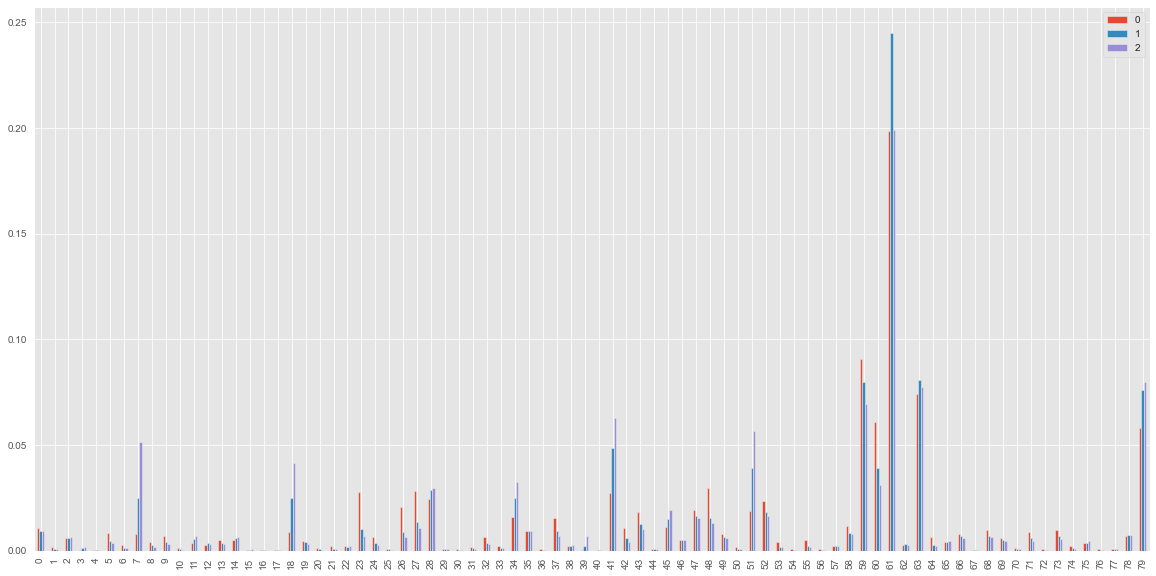

In [75]:
pd.DataFrame(action_dist_berts_prior_wrights[0]).plot(kind='bar', figsize=(20,10))

### Testing BerTS without Prior weights (non production)

In [76]:
# define BernoulliTS as an evaluation policy
evaluation_policy_berts_simulation = BernoulliTS(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=1,
    random_state=12345,
)

evaluation_policy_berts_simulation

BernoulliTS(n_actions=80, len_list=3, batch_size=1, random_state=12345, alpha=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), beta=array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]), is_zozotown_prior=False, campaign=None, policy_name='bts')

In [77]:
action_dist_berts_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_berts_simulation
)

100%|██████████| 1374327/1374327 [00:48<00:00, 28353.89it/s]


In [78]:
action_dist_berts_simulation[0].T

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.

<AxesSubplot:>

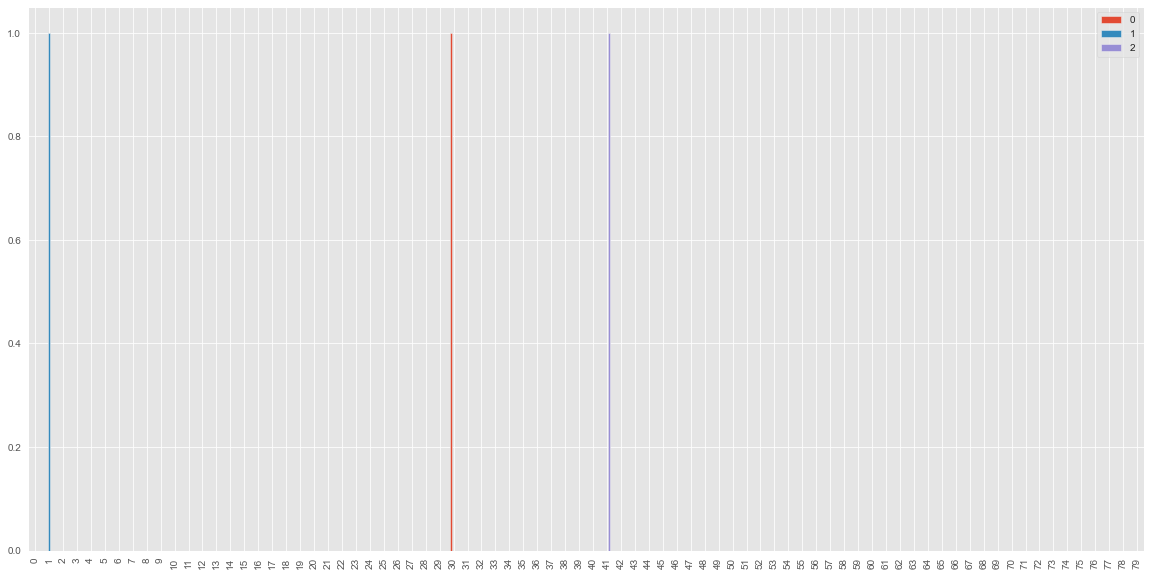

In [79]:
pd.DataFrame(action_dist_berts_simulation[99999]).plot(kind='bar', figsize=(20,10))

### Testing LinTS - contextual (non production)

In [117]:
dataset_random_all.context

(1374327, 26)

In [122]:
# define BernoulliTS as an evaluation policy
evaluation_policy_lints_simulation = LinTS(
    dim=dataset_random_all.dim_context,
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    batch_size=1000,
    random_state=12345,
)

evaluation_policy_lints_simulation

LinTS(dim=26, n_actions=80, len_list=3, batch_size=1000, random_state=12345)

In [123]:
action_dist_lints_simulation = run_bandit_simulation(
    bandit_feedback=bandit_feedback_random_all,
    policy=evaluation_policy_lints_simulation,
)

 25%|██▌       | 349341/1374327 [1:43:55<5:04:56, 56.02it/s]  


KeyboardInterrupt: 

In [ ]:
action_dist_lints_simulation[0].T

In [ ]:
pd.DataFrame(action_dist_lints_simulation[99999]).plot(kind='bar', figsize=(20,10))

## (3) Off-Policy Evaluation (OPE)
Our next step is OPE, which aims to estimate the performance of evaluation policies using logged bandit data and OPE estimators.

Here, we use 
- `obp.ope.InverseProbabilityWeighting` (IPW)
- `obp.ope.DirectMethod` (DM)
- `obp.ope.DoublyRobust` (DR)

as estimators and visualize the OPE results.

### (3-1) Obtaining a reward estimator
A reward estimator $\hat{q}(x,a)$ is needed for model dependent estimators such as DM or DR.

$\hat{q}(x,a) \approx \mathbb{E} [r \mid x,a]$

please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure.

In [80]:
# estimate the expected rewards by using an ML model (Logistic Regression here)
# the estimated rewards are used by model-dependent estimators such as DM and DR
regression_model_lr = RegressionModel(
    n_actions=dataset_random_all.n_actions,
    len_list=dataset_random_all.len_list,
    action_context=dataset_random_all.action_context,
    base_model=LogisticRegression(max_iter=1000, random_state=12345),
)

regression_model_lr

RegressionModel(base_model=LogisticRegression(max_iter=1000, random_state=12345), n_actions=80, len_list=3, action_context=array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
         9.72751855e-01],
       [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
        -5.21473497e-01],
       [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
         1.90943043e+00],
       [ 1.10000000e+01,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 9.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         3.48299469e-01],
       [ 0.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -2.76152917e-01],
       [ 1.10000000e+01,  1.60000000e+01,  1.00000000e+00,
        -6.55284723e-01],
       [ 9.00000000e+00,  2.00000000e+00,  2.00000000e+00,
        -3.87662271e-01],
       [ 3.00000000e+00,  1

In [81]:
# please refer to https://arxiv.org/abs/2002.08536 about the details of the cross-fitting procedure

estimated_rewards_by_reg_model_lr = regression_model_lr.fit_predict(
    context=bandit_feedback_random_all["context"],
    action=bandit_feedback_random_all["action"],
    reward=bandit_feedback_random_all["reward"],
    position=bandit_feedback_random_all["position"],
    pscore=bandit_feedback_random_all["pscore"],
    n_folds=3, # use 3-fold cross-fitting
    random_state=12345,
)

estimated_rewards_by_reg_model_lr.shape

(1374327, 80, 3)

In [82]:
estimated_rewards_by_reg_model_lr[0].T

array([[0.00391504, 0.00377535, 0.00310703, 0.00361917, 0.00349915,
        0.00363982, 0.00434539, 0.00543037, 0.00322345, 0.0039747 ,
        0.00446413, 0.00309952, 0.00398862, 0.00425543, 0.00299228,
        0.0029893 , 0.00328328, 0.0031797 , 0.00296042, 0.0031858 ,
        0.00316183, 0.00308738, 0.00287096, 0.00297927, 0.00297812,
        0.00297697, 0.00361917, 0.00406055, 0.00402416, 0.00442377,
        0.00397207, 0.0039736 , 0.00353396, 0.00353396, 0.00485989,
        0.00485989, 0.00420379, 0.00426901, 0.00287589, 0.00431124,
        0.0039747 , 0.00455947, 0.00451592, 0.00308823, 0.00287414,
        0.00331218, 0.00428965, 0.00467011, 0.00404785, 0.00328485,
        0.00380262, 0.00450601, 0.00504031, 0.00327637, 0.00403518,
        0.00452845, 0.00403518, 0.00363662, 0.00412287, 0.0033885 ,
        0.00355267, 0.00391288, 0.00469743, 0.00582644, 0.00441988,
        0.0033186 , 0.00512545, 0.00363781, 0.00314392, 0.00320417,
        0.00362146, 0.00359623, 0.00355326, 0.00

<AxesSubplot:>

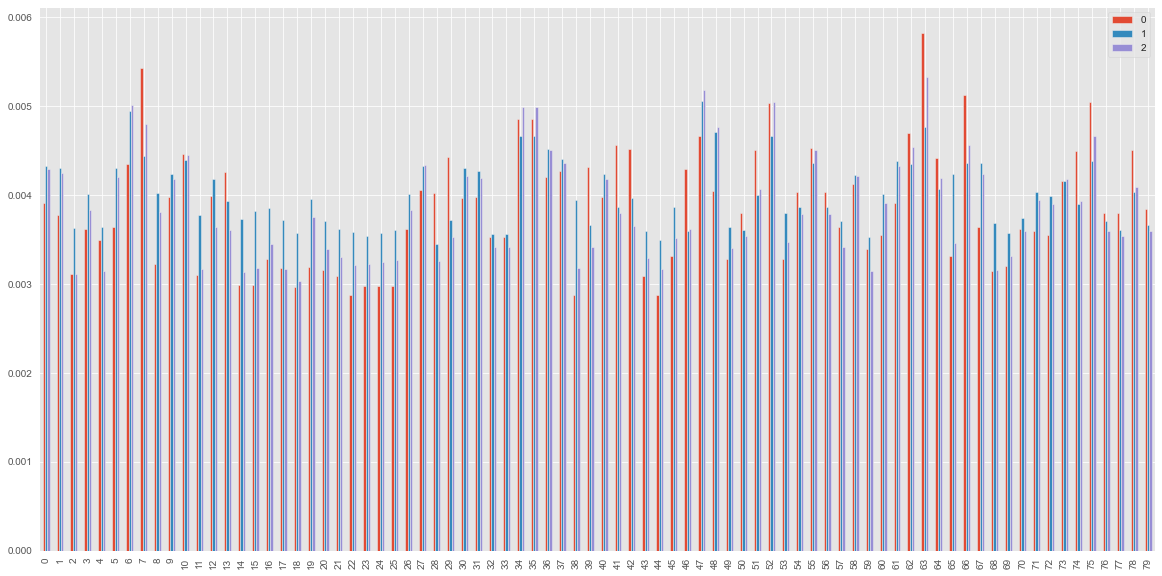

In [83]:
pd.DataFrame(estimated_rewards_by_reg_model_lr[0]).plot(kind='bar', figsize=(20,10))

### (3-2) Off-Policy Evaluation
$V(\pi_e) \approx \hat{V} (\pi_e; \mathcal{D}_b, \theta)$ using DM, IPW, and DR

In [84]:
# estimate the policy value of BernoulliTS based on its action choice probabilities
# it is possible to set multiple OPE estimators to the `ope_estimators` argument
ope_random_all = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[InverseProbabilityWeighting(), DirectMethod(), DoublyRobust()]
)

ope_random_all

OffPolicyEvaluation(bandit_feedback={'n_rounds': 1374327, 'n_actions': 80, 'action': array([21, 43, 62, ..., 17, 48, 78]), 'position': array([0, 1, 2, ..., 0, 2, 1]), 'reward': array([0, 0, 0, ..., 0, 0, 0]), 'pscore': array([0.0125, 0.0125, 0.0125, ..., 0.0125, 0.0125, 0.0125]), 'context': array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8), 'action_context': array([[ 9.00000000e+00,  6.00000000e+00,  1.00000000e+00,
        -4.99171626e-01],
       [ 1.00000000e+01,  6.00000000e+00,  1.00000000e+00,
        -5.43775368e-01],
       [ 1.00000000e+01,  8.00000000e+00,  6.00000000e+00,
         9.72751855e-01],
       [ 1.10000000e+01,  1.00000000e+00,  3.00000000e+00,
        -5.21473497e-01],
       [ 3.00000000e+00,  1.90000000e+01,  6.00000000e+00,
         1.90943043e+00],
       [ 1.10000000e+01,  6.00000000e+00,  1.0

#### BTS Prior ZozoTown Weights

In [86]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_berts_prior_wrights, estimated_interval_berts_prior_wrights = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_berts_prior_wrights

,estimated_policy_value,relative_estimated_policy_value
ipw,0.004694,1.352924
dm,0.003653,1.052863
dr,0.004685,1.350533


In [87]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_berts_prior_wrights

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.004697,0.004467,0.004863
dm,0.003651,0.003645,0.003653
dr,0.004691,0.004449,0.004859


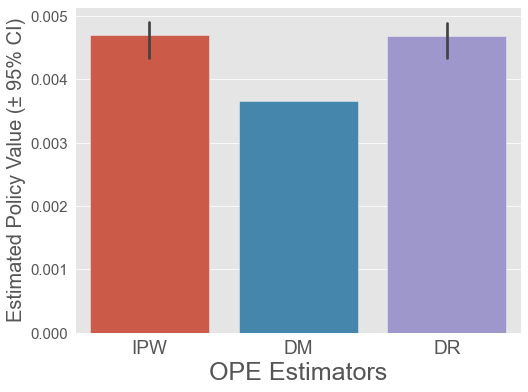

In [88]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

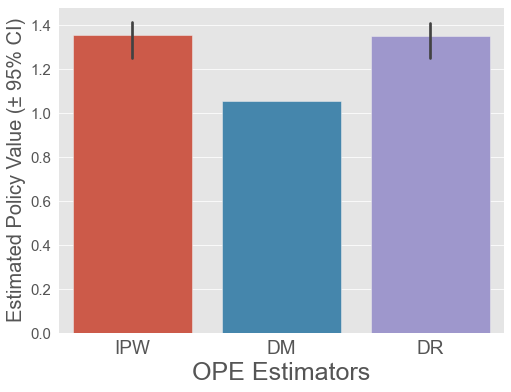

In [89]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

#### BTS Simulation

In [93]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_berts_simulation, estimated_interval_berts_simulation = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_berts_simulation

,estimated_policy_value,relative_estimated_policy_value
ipw,0.003143,0.906040
dm,0.003505,1.010231
dr,0.003255,0.938239


In [94]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_berts_simulation

,mean,95.0% CI (lower),95.0% CI (upper)
ipw,0.003083,0.002240,0.003872
dm,0.003505,0.003503,0.003506
dr,0.003198,0.002364,0.003971


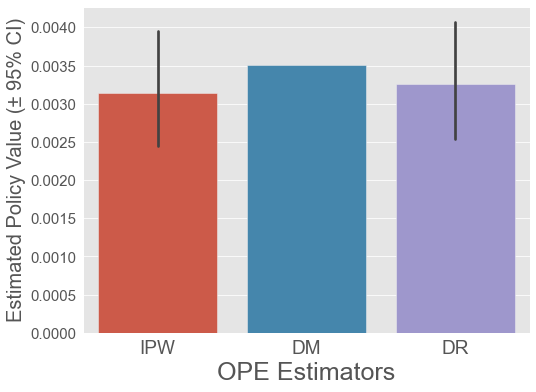

In [95]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

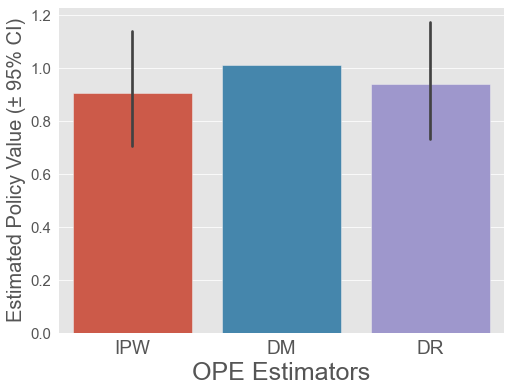

In [96]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_berts_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

Note that the OPE demonstration here is with the small size example version of our dataset. 

Please use its full size version (https://research.zozo.com/data.html) to produce more reasonable results.

#### LinTS Simulation

In [ ]:
# `summarize_off_policy_estimates` returns pandas dataframes including the OPE results
estimated_policy_value_lints_simulation, estimated_interval_lints_simulation = ope_random_all.summarize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling.
    random_state=12345,
)

# the estimated policy value of the evaluation policy (the BernoulliTS policy)
# relative_estimated_policy_value is the policy value of the evaluation policy relative to the ground-truth policy value of the behavior policy (the Random policy here)
estimated_policy_value_lints_simulation

In [ ]:
# confidence intervals of policy value of BernoulliTS estimated by OPE estimators
# (`mean` values in this dataframe is also estimated via the non-parametric bootstrap procedure
# and is a bit different from the above values in `estimated_policy_value`)
estimated_interval_lints_simulation

In [ ]:
# visualize the estimated policy values of BernoulliTS and their 95% confidence intervals (estimated by bootstrap)
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    random_state=12345,
)

In [ ]:
# by activating the `is_relative` option
# we can visualize the estimated policy value of the evaluation policy
# relative to the ground-truth policy value of the behavior policy
ope_random_all.visualize_off_policy_estimates(
    action_dist=action_dist_lints_simulation,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=100, # number of resampling performed in bootstrap sampling
    is_relative=True,
    random_state=12345,
)

#### Trying `visualize_off_policy_estimates_of_multiple_policies`

- this method only works with 2 OPE methodologies

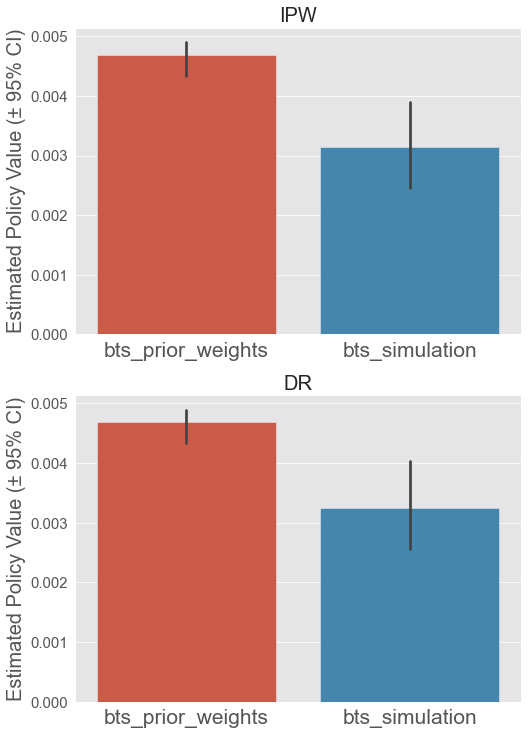

In [105]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["bts_prior_weights", "bts_simulation"],
    action_dist_list=[action_dist_berts_prior_wrights, action_dist_berts_simulation],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10,
    random_state=12345,
)

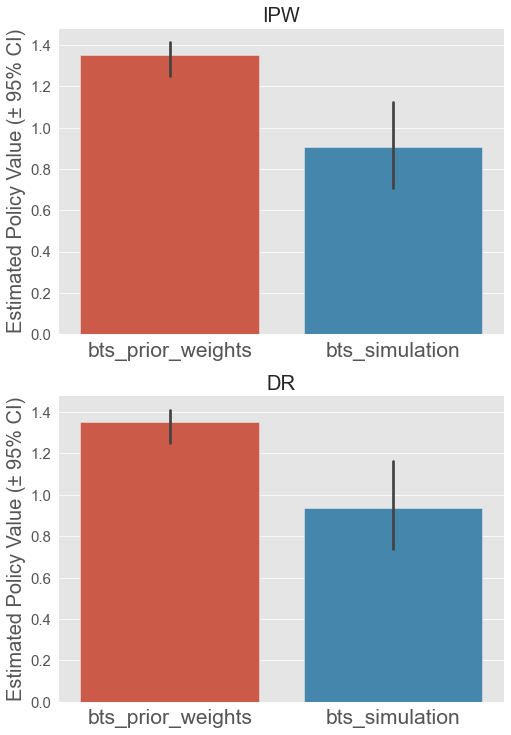

In [106]:
ope1 = OffPolicyEvaluation(
    bandit_feedback=bandit_feedback_random_all,
    ope_estimators=[InverseProbabilityWeighting(), DoublyRobust()]
)

ope1.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["bts_prior_weights", "bts_simulation"],
    action_dist_list=[action_dist_berts_prior_wrights, action_dist_berts_simulation],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    n_bootstrap_samples=10,
    random_state=12345,
    is_relative=True
)

## (4) Evaluation of OPE

Our final step is the **evaluation of OPE**, which evaluates the estimation accuracy of OPE estimators.

Specifically, we asses the accuracy of DM, IPW, and DR by comparing their estimations with the ground-truth policy value estimated via the on-policy estimation from Open Bandit Dataset.

**This type of evaluation of OPE is possible, because Open Bandit Dataset contains a set of *multiple* different logged bandit datasets collected by running different policies on the same platform at the same time.**

Please refer to [the documentation](https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html) for the details about the evaluation of OPE protocol.

### (4-1) Approximate the Ground-truth Policy Value 
With Open Bandit Dataset, we can estimate the ground-truth policy value of the evaluation policy in an on-policy manner as follows.

$V(\pi_e) \approx \frac{1}{|\mathcal{D}_{e}|} \sum_{i=1}^{|\mathcal{D}_{e}|} \mathbb{E}_{n} [r_i]$

$ \mathcal{D}_e := \{(x_i,a_i,r_i)\} $ ($(x,a,r) \sim p(x)\pi_e(a | x)p(r | x,a) $) is the log data collected by the evaluation policy (, which is used only for approximating the ground-truth policy value).

We can compare the policy values estimated by OPE estimators with this on-policy estimate to evaluate the accuracy of OPE.

In [98]:
# we first calculate the ground-truth policy value of the evaluation policy
# , which is estimated by averaging the factual / Empirical (observed) rewards contained in the dataset (on-policy estimation)
policy_value_bts_online = OpenBanditDataset.calc_on_policy_policy_value_estimate(
    behavior_policy='bts', campaign='all', data_path=data_path_complete
)

In [99]:
policy_value_bts_online

0.004953225649823585

In [101]:
# other way - using raw data

dataset_bts_all.obtain_batch_bandit_feedback()["reward"].mean()

0.004953225649823585

In [107]:
# Baseline policy Value

dataset_random_all.obtain_batch_bandit_feedback()["reward"].mean()

0.0034693344451502445

### (4-2) Evaluation of OPE

We can evaluate the estimation performance of OPE estimators by comparing the estimated policy values of the evaluation with its ground-truth as follows.

- $\textit{relative-ee} (\hat{V}; \mathcal{D}_b) := \left| \frac{V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b)}{V(\pi_e)} \right|$ (relative estimation error; relative-ee)
- $\textit{SE} (\hat{V}; \mathcal{D}_b) := \left( V(\pi_e) - \hat{V} (\pi_e; \mathcal{D}_b) \right)^2$ (squared error; se)


**We can iterate the above process several times to get more reliable results.**
- also mentioned in paper
- or here: https://zr-obp.readthedocs.io/en/latest/evaluation_ope.html

  - the above states that we can calculate the OPE performance on multiple bootstrapped datasets to get more robust results.

In [102]:
# evaluate the estimation performance of the OPE estimators 
# `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators

relative_ee_random_all_bts_prior_weights = ope_random_all.summarize_estimators_comparison(
    ground_truth_policy_value=policy_value_bts_online,
    action_dist=action_dist_berts_prior_wrights,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
    metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
)

# estimation performances of the three estimators (lower means accurate)
relative_ee_random_all_bts_prior_weights

,relative-ee
ipw,0.052386
dm,0.262554
dr,0.054061


In [103]:
# se_random_all_bts_prior_weights = ope_random_all.summarize_estimators_comparison(
#     ground_truth_policy_value=policy_value_bts_online,
#     action_dist=action_dist_berts_prior_wrights,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     metric="se", #  "se" (squared error)
# )
#
# # estimation performances of the three estimators (lower means accurate)
# se_random_all_bts_prior_weights

#### Evaluation of OPE will not work for Offline Simulation because it requires TRUE Online Policy Value

In [104]:
# # evaluate the estimation performance of the OPE estimators
# # `evaluate_performance_of_estimators` returns a dictionary containing estimation performance of given estimators
#
# relative_ee_random_all_bts_simulation = ope_random_all.summarize_estimators_comparison(
#     ground_truth_policy_value=policy_value_bts_online,
#     action_dist=action_dist_berts_simulation,
#     estimated_rewards_by_reg_model=estimated_rewards_by_reg_model_lr,
#     metric="relative-ee", # "relative-ee" (relative estimation error) or "se" (squared error)
# )
#
# # estimation performances of the three estimators (lower means accurate)
# relative_ee_random_all_bts_simulation



Please see [examples/obd](../obd) for a more sophisticated example of the evaluation of OPE with the Open Bandit Dataset.